In [68]:
#Python version
!python --version

Python 3.8.5


https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html

In [69]:
#Install uninstalled modules, comment if it's already installed

#!pip install ipykernel
#!pip install MetaTrader5==5.0.34
#!pip install gym
#!pip install gym-anytrading
#!pip install tensorflow
#!pip install tf_agents

In [70]:
#Import needed modules
import gym
import gym_anytrading
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK

import numpy as np
import tensorflow as tf
from tf_agents.agents.dqn.dqn_agent import DqnAgent, DdqnAgent
from tf_agents.networks.q_network import QNetwork
from tf_agents.environments import tf_py_environment

from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

import matplotlib.pyplot as plt
import pandas as pd
import random, datetime, os, copy
import MetaTrader5 as mt5

In [71]:
# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    mt5.shutdown()
 
# display data on MetaTrader 5 version
print(mt5.version())

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

"""
# Initialize Metatrader on a certain day
if datetime.datetime.now() == weekdays:
    # now connect to another trading account specifying the password
    account = #Account number
    password = #Password number
    server = #Server name
    authorized=mt5.login(account, password, server)
    if authorized:
        # display trading account data 'as is'
        print(mt5.account_info())
        # display trading account data in the form of a list
        print("Show account_info()._asdict():")
        account_info_dict = mt5.account_info()._asdict()
        for prop in account_info_dict:
            print("  {}={}".format(prop, account_info_dict[prop]))
    else:
        print("failed to connect at account #{}, error code: {}".format(account, mt5.last_error()))
# shut down connection to the MetaTrader 5 terminal
else:
    mt5.shutdown()
"""

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34
initialize() failed, error code = (-10003, 'IPC initialize failed, MetaTrader 5 x64 not found')
(0, 0, '')


'\n# Initialize Metatrader on a certain day\nif datetime.datetime.now() == weekdays:\n    # now connect to another trading account specifying the password\n    account = #Account number\n    password = #Password number\n    server = #Server name\n    authorized=mt5.login(account, password, server)\n    if authorized:\n        # display trading account data \'as is\'\n        print(mt5.account_info())\n        # display trading account data in the form of a list\n        print("Show account_info()._asdict():")\n        account_info_dict = mt5.account_info()._asdict()\n        for prop in account_info_dict:\n            print("  {}={}".format(prop, account_info_dict[prop]))\n    else:\n        print("failed to connect at account #{}, error code: {}".format(account, mt5.last_error()))\n# shut down connection to the MetaTrader 5 terminal\nelse:\n    mt5.shutdown()\n'


env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (800,)
> signal_features.shape: (800, 2)
> max_possible_profit: 1.2961057376950926


> possible action: Discrete(2)
> observation space: Box(-inf, inf, (10, 2), float32)


> signal features:  [[ 1.05227e+00  0.00000e+00]
 [ 1.05282e+00  5.50000e-04]
 [ 1.05281e+00 -1.00000e-05]
 ...
 [ 1.06135e+00  0.00000e+00]
 [ 1.06156e+00  2.10000e-04]
 [ 1.06211e+00  5.50000e-04]]


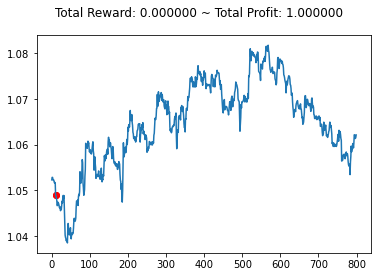

In [72]:
env = gym.make('forex-v0',
               df = FOREX_EURUSD_1H_ASK,
               window_size = 10,
               frame_bound = (10, 800), #Max 6225 Rows of data
               unit_side = 'right')

seed = 42
env.seed(seed)
eps = np.finfo(np.float32).eps.item()

print()
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("\n")
print("> possible action:", env.action_space)
print("> observation space:", env.observation_space)
print("\n")
print("> signal features: ", env.signal_features)

env.reset() # Uncomment if you need it.
env.render()


In [73]:
print(env.df)
print("\n")
env.df.info()

                        Open     High      Low    Close        Volume
Time                                                                 
2017-01-01 22:00:00  1.05236  1.05253  1.05221  1.05227  1.435400e+08
2017-01-01 23:00:00  1.05227  1.05426  1.05226  1.05282  2.531400e+08
2017-02-01 00:00:00  1.05283  1.05283  1.05268  1.05281  1.314000e+08
2017-02-01 01:00:00  1.05282  1.05286  1.05225  1.05240  2.739400e+08
2017-02-01 02:00:00  1.05239  1.05240  1.05164  1.05220  2.581400e+08
...                      ...      ...      ...      ...           ...
2017-12-29 17:00:00  1.20224  1.20257  1.20191  1.20218  9.283300e+09
2017-12-29 18:00:00  1.20218  1.20242  1.20122  1.20139  7.366750e+09
2017-12-29 19:00:00  1.20139  1.20144  1.20073  1.20096  7.205770e+09
2017-12-29 20:00:00  1.20098  1.20109  1.19978  1.19982  6.679810e+09
2017-12-29 21:00:00  1.19984  1.20130  1.19931  1.20075  4.885530e+09

[6225 rows x 5 columns]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6225 entri

In [74]:
'''
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']].to_numpy()[start:end]
    return prices, signal_features

prices, signal_features = my_process_data(
            df = FOREX_EURUSD_1H_ASK,
            window_size = 10,
            frame_bound = (10, 800), #Max 6225 Rows of data
)

print(prices)
print("\n")
print(signal_features)
'''

'\ndef my_process_data(df, window_size, frame_bound):\n    start = frame_bound[0] - window_size\n    end = frame_bound[1]\n    prices = df.loc[:, \'Low\'].to_numpy()[start:end]\n    signal_features = df.loc[:, [\'Open\', \'High\', \'Low\', \'Close\', \'Volume\']].to_numpy()[start:end]\n    return prices, signal_features\n\nprices, signal_features = my_process_data(\n            df = FOREX_EURUSD_1H_ASK,\n            window_size = 10,\n            frame_bound = (10, 800), #Max 6225 Rows of data\n)\n\nprint(prices)\nprint("\n")\nprint(signal_features)\n'

info: {'total_reward': 348.3000000000412, 'total_profit': 0.9618007306900311, 'position': 0}


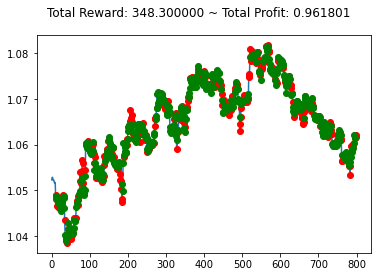

In [75]:
# Based on random actions

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

In [76]:
# Global Parameter
NUMBER_EPISODES = 10000
COLLECTION_STEPS = 1
BATCH_SIZE = 64
EVAL_EPISODES = 15
EVAL_INTERVAL = 1000

In [83]:
train_env = env
test_env = env

hidden_layers = 128

dqn_network = QNetwork(
    train_env.observation_space,
    train_env.action_space,
    fc_layer_params=hidden_layers)

ddqn_network = QNetwork(
    train_env.observation_space,
    train_env.action_space,
    fc_layer_params=hidden_layers)

AttributeError: 'Discrete' object has no attribute 'maximum'
  In call to configurable 'QNetwork' (<class 'tf_agents.networks.q_network.QNetwork'>)

In [64]:
counter = tf.Variable(0)

dqn_agent = DqnAgent(
    train_env.action_space,
    q_network = dqn_network,
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3),
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter = counter)

ddqn_agent = DdqnAgent(
    train_env.action_space,
    q_network = ddqn_network,
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3),
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter = counter)

dqn_agent.initialize()
ddqn_agent.initialize()

NameError: name 'dqn_network' is not defined

In [78]:
def get_average_reward(env, policy, episodes=10):

    total_reward = 0.0

    for _ in range(episodes):
        time_step = env.reset()
        episode_reward = 0.0

    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        episode_reward += time_step.reward
    
    total_reward += episode_reward
    avg_reward = total_reward / episodes
    
    return avg_reward.numpy()[0]

In [82]:
class ExperienceReplay(object):
    def __init__(self, agent, enviroment):
        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=agent.collect_data_spec,
            batch_size=env.batch_size,
            max_length=50000)
        
        self._random_policy = RandomTFPolicy(train_env.time_step_spec(),
                                                enviroment.action_spec())
        
        self._fill_buffer(train_env, self._random_policy, steps=100)
        
        self.dataset = self._replay_buffer.as_dataset(
            num_parallel_calls=3, 
            sample_batch_size=BATCH_SIZE, 
            num_steps=2).prefetch(3)

        self.iterator = iter(self.dataset)
    
    def _fill_buffer(self, enviroment, policy, steps):
        for _ in range(steps):
            self.timestamp_data(enviroment, policy)
            
    def timestamp_data(self, environment, policy):
        time_step = env.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = env.step(action_step.action)
        timestamp_trajectory = trajectory.from_transition(time_step, action_step, next_time_step)

        self._replay_buffer.add_batch(timestamp_trajectory)

In [81]:
def train(agent):
    experience_replay = ExperienceReplay(agent, train_env)

    agent.train_step_counter.assign(0)

    avg_reward = get_average_reward(test_env, agent.policy, EVAL_EPISODES)
    rewards = [avg_reward]

    for _ in range(NUMBER_EPOSODES):

        for _ in range(COLLECTION_STEPS):
            ExperienceReplay.timestamp_data(train_env, agent.collect_policy)

        experience, info = next(experience_replay.iterator)
        train_loss = agent.train(experience).loss

        if agent.train_step_counter.numpy() % EVAL_INTERVAL == 0:
            avg_reward = get_average_reward(test_env, agent.policy, EVAL_EPISODES)
            print('Episode {0} - Average reward = {1}, Loss = {2}.'.format(
					agent.train_step_counter.numpy(), avg_reward, train_loss))
            rewards.append(avg_reward)
            
    return rewards

print("**********************************")
print("Training DQN")
print("**********************************")
dqn_reward = train(dqn_agent)

print("**********************************")
print("Training DDQN")
print("**********************************")
ddqn_reward = train(ddqn_agent)

**********************************
Training DQN
**********************************


NameError: name 'dqn_agent' is not defined